<a href="https://colab.research.google.com/github/mmchaava/clusters-kNN/blob/main/Final_Assignment_Best_Spot_BWR_10_AGO_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p>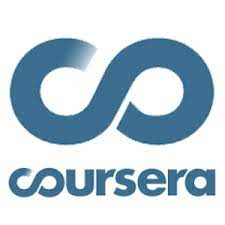</p>

<h1>Segmenting and Clustering Neighborhoods on São Paulo City</h1> <h1>The Best spot for a Brewery</h1>
<h2>Scraping the data from Internet</h2>

This script aim to select the hot points in São Paulo for brewery and beer related restaurants. The key objective is join enough data to assure best place for new beer business related shops in the city.

The main topics is: 

- Summarise the streets São Paulo city in a dataframe with postal codes and geo coordinates.
- Join a side dataframe with the streets names for all key beer stores in São Paulo.
- Select the places with higher citations on google.
- Apply a classification algorithm to group this places.
- Represent the results in a folium map.

Reference sites:

 São Paulo Streets : https://cep.guiamais.com.br/busca/sao+paulo-sp?page=1

 Beer places : https://www.listamais.com.br



# INSTALL AND IMPORT

## Install Libraries


In [ ]:
!pip install folium

In [ ]:
!pip install pycep_correios

     |████████████████████████████████| 100 kB 4.0 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 


In [ ]:
!pip install geopy

In [ ]:
!pip install alive_progress

## Import Libraries

In [ ]:
import folium # plotting library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import requests # library to handle request

import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

# tranforming json file into a pandas dataframe library
import json

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML
from IPython.display import display_html

#libraries for geolocation
import pycep_correios
import geopy
from geopy.geocoders import Nominatim

#Beatiful Soap
import json
import urllib3
from bs4 import BeautifulSoup
import pandas as pd
import requests

#progress bar
from alive_progress import alive_bar
from tqdm import tqdm

#time pause
from random import randint
from time import sleep

#google colab
from google.colab import files

print('Libraries imported.')

Libraries imported.


### Classes

In [ ]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

# FINDING - Beers Stores in São Paulo

## SCRAPING THE DATA

### Acquiring the Data from Reference Site

In [ ]:
def carrega(pag):
  
  site_txt="https://www.listamais.com.br/ResultadoBusca/PaginacaoPagina?vGlobalCidade=75&vGlobalBusca=cervejaria&vGlobalSize=10&vGlobalOrdem=melhor_resultado&vGlobalRestricoes=&vGlobalTipoRestricao=and&vGlobalCidadeDescricao=S%C3%A3o+Paulo++-+SP&vGlobalCampoTravado=0&vGlobalCursorAnterior=2&vGlobalCursorProximo=4&vGlobalCamposAceitos=todos&vGlobalQuantidadeDeRegistros=2250&vGlobalCampoTravadoDescricaoPaginacao=&vGlobalExibeh1=Cervejaria&vGlobalIntervalo=&vGlobalComecoPaginacao=10&sLocalizacao=&sCluster=&filtros=&segmento=&buscaES=true&buscaInfoCod=&total_paginas=225&pagina_atual=3&localizacaoUsuarioPaginacao=&cidadePaginacao=&proximo=col-md-12+NoPadding2%40ViewBag.proximo&usuarioPaginacao=0&random_ordem=0&sPagina="+str(pag)
  #site_txt="https://www.guiamais.com.br/encontre?searchbox=true&what=cervejaria&where=s%C3%A3o+paulo%2C+sp&page="+str(pag)
  URL = (site_txt)
  page = requests.get(URL)
  soup = BeautifulSoup(page.content, "html.parser")
  job_elements = soup.find_all("script", type="application/ld+json")

  return job_elements

In [ ]:
# checking the authorization of the searched site for scrapping

r=requests.get("https://www.listamais.com.br/ResultadoBusca/PaginacaoPagina?vGlobalCidade=75&vGlobalBusca=cervejaria&vGlobalSize=10&vGlobalOrdem=melhor_resultado&vGlobalRestricoes=&vGlobalTipoRestricao=and&vGlobalCidadeDescricao=S%C3%A3o+Paulo++-+SP&vGlobalCampoTravado=0&vGlobalCursorAnterior=2&vGlobalCursorProximo=4&vGlobalCamposAceitos=todos&vGlobalQuantidadeDeRegistros=2250&vGlobalCampoTravadoDescricaoPaginacao=&vGlobalExibeh1=Cervejaria&vGlobalIntervalo=&vGlobalComecoPaginacao=10&sLocalizacao=&sCluster=&filtros=&segmento=&buscaES=true&buscaInfoCod=&total_paginas=225&pagina_atual=3&localizacaoUsuarioPaginacao=&cidadePaginacao=&proximo=col-md-12+NoPadding2%40ViewBag.proximo&usuarioPaginacao=0&random_ordem=0&sPagina=1")

if r.status_code==200:
  print (f"{bcolors.OKGREEN}This site accept web scrapping.")
else:
  print(f"{bcolors.FAIL}Scrapping this site is not allowed.")



This site accept web scrapping.


In [ ]:
pag=0
df=pd.DataFrame()
df_t=pd.DataFrame()

for pag in tqdm(range(1,226)):

  df=pd.concat([df,df_t])

  job_elements = carrega(pag)

  # inital values - set up
  texto = str(job_elements)
  procura = '"name": "'
  s = 0
  frag = ""
  lista_n = []
  pos=0
  cond=','

  procura_l = ['"name": "',
                 '"addressLocality":"',
                 '"postalCode":"',
            '"streetAddress":"']
           

  col_nom   = ["Store_Name",
                 "Locality",
                 "Postal_Code",
              "Street_Address"]
             
  for i in range(0,len(procura_l)):

    procura = procura_l[i]

    while not(pos==-1):
      txt = ""
      frag = ""
      pos  = texto.find( procura , s )
      pos_ = pos + len(procura)

      while not(frag==cond):
        frag = texto[pos_:pos_+1]
        txt = txt + frag
        pos_ = pos_ + 1
  
      s=pos_
      txt.replace('",',"")
      lista_n.append(txt)

    df_t[col_nom[i]]=lista_n

    s=0
    frag = ""
    lista_n = []
    pos=0

    if i==2 :
      cond = '"' 
    else:
      cond = ','


df.reset_index(inplace=True, drop=True)
df=pd.DataFrame(data=df, columns=col_nom)

df

100%|██████████| 225/225 [05:34<00:00,  1.49s/it]


,Store_Name,Locality,Postal_Code,Street_Address
0,"Lanchonete Choperia Bilu Bilu Ltda - Me "",","São Paulo "",","08140-000"",","Rua Tibúrcio Sousa, 148, Itaim Paulista"""
1,"Choperia Takeu Ltda "",","São Paulo "",","01510-001"",","Rua Glória, 523, Liberdade"""
2,"Cervejaria Nacional "",","São Paulo "",","54200-01 "",","Avenida Pedroso Morais, 604, """
3,"Toca do Nego Veio Bar & Cervejaria "",","São Paulo "",","53520-50 "",","Rua Doutor Teodoro Quartim Barbosa, 114, """
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga"""
...,...,...,...,...
2459,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2460,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2461,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """
2462,"W W Auto Shop "",","São Paulo "",","21250-00 "",","Rua Mere Amedea, 90, """


### Cleasing and Pre Processing the Data

In [ ]:
# Remove not valide rows

for i in range(0,df.shape[0]):
  proc=str(df['Store_Name'].loc[i:i])
  if proc[0:18+len(str(i))] == str(i)+'     type="applica':
    df['Store_Name'].loc[i:i]="deletar"

df.drop(df[df['Store_Name'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

df


,Store_Name,Locality,Postal_Code,Street_Address
0,"Lanchonete Choperia Bilu Bilu Ltda - Me "",","São Paulo "",","08140-000"",","Rua Tibúrcio Sousa, 148, Itaim Paulista"""
1,"Choperia Takeu Ltda "",","São Paulo "",","01510-001"",","Rua Glória, 523, Liberdade"""
2,"Cervejaria Nacional "",","São Paulo "",","54200-01 "",","Avenida Pedroso Morais, 604, """
3,"Toca do Nego Veio Bar & Cervejaria "",","São Paulo "",","53520-50 "",","Rua Doutor Teodoro Quartim Barbosa, 114, """
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga"""
...,...,...,...,...
2235,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """
2236,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2237,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2238,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """


In [ ]:
# Cleanning Data

street=""
number=""
neighb=""

street_l=[]
number_l=[]
neighb_l=[]

for i in range(0,df.shape[0]):
  proc=str(df['Street_Address'].loc[i:i])
  proc_=proc.split(sep=",")

  if not(len(proc_)==4):
    df['Street_Address'].loc[i:i]="deletar"

df.drop(df[df['Street_Address'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

df

,Store_Name,Locality,Postal_Code,Street_Address
0,"Lanchonete Choperia Bilu Bilu Ltda - Me "",","São Paulo "",","08140-000"",","Rua Tibúrcio Sousa, 148, Itaim Paulista"""
1,"Choperia Takeu Ltda "",","São Paulo "",","01510-001"",","Rua Glória, 523, Liberdade"""
2,"Cervejaria Nacional "",","São Paulo "",","54200-01 "",","Avenida Pedroso Morais, 604, """
3,"Toca do Nego Veio Bar & Cervejaria "",","São Paulo "",","53520-50 "",","Rua Doutor Teodoro Quartim Barbosa, 114, """
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga"""
...,...,...,...,...
2229,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """
2230,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """
2231,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """
2232,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """


In [ ]:
# Detailing Address

df[[ 'Street_Name', 'Number', 'Neighborhood' ]] = df['Street_Address'].str.split(',', expand=True)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood
0,"Lanchonete Choperia Bilu Bilu Ltda - Me "",","São Paulo "",","08140-000"",","Rua Tibúrcio Sousa, 148, Itaim Paulista""",Rua Tibúrcio Sousa,148,"Itaim Paulista"""
1,"Choperia Takeu Ltda "",","São Paulo "",","01510-001"",","Rua Glória, 523, Liberdade""",Rua Glória,523,"Liberdade"""
2,"Cervejaria Nacional "",","São Paulo "",","54200-01 "",","Avenida Pedroso Morais, 604, """,Avenida Pedroso Morais,604,""""
3,"Toca do Nego Veio Bar & Cervejaria "",","São Paulo "",","53520-50 "",","Rua Doutor Teodoro Quartim Barbosa, 114, """,Rua Doutor Teodoro Quartim Barbosa,114,""""
4,"Restaurante Choperia Tche Gaúcho Ltda "",","São Paulo "",",""",","Estrada Guarapiranga, 884, Guarapiranga""",Estrada Guarapiranga,884,"Guarapiranga"""
...,...,...,...,...,...,...,...
2229,"Shop Car Moraes Serviços Automotivos S/c "",","São Paulo "",",""",","Rua Odovalho Jr, 475, """,Rua Odovalho Jr,475,""""
2230,"Qg Auto Shop - Jd Peri Peri "",","São Paulo "",",""",","Rua Salvado Isoleu, 85, """,Rua Salvado Isoleu,85,""""
2231,Universal Distribuidora de Maçanetas e Ferrage...,"São Paulo "",",""",","Rua Belamino José Costa, 19, """,Rua Belamino José Costa,19,""""
2232,"Triplicar Auto Shop "",","São Paulo "",",""",","Av Guapira, 1650, Bro Vl Constanca """,Av Guapira,1650,"Bro Vl Constanca """


In [ ]:
# Polishing data

df['Store_Name'] = df.Store_Name.replace('",', '', regex = True)

df['Locality'] = df.Locality.replace('",', '', regex = True)

df['Postal_Code'] = df.Postal_Code.replace('",', '', regex = True)

df['Street_Address'] = df.Street_Address.replace('"', '', regex = True)

df['Neighborhood'] = df.Neighborhood.replace('"', '', regex = True)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood
0,Lanchonete Choperia Bilu Bilu Ltda - Me,São Paulo,08140-000,"Rua Tibúrcio Sousa, 148, Itaim Paulista",Rua Tibúrcio Sousa,148,Itaim Paulista
1,Choperia Takeu Ltda,São Paulo,01510-001,"Rua Glória, 523, Liberdade",Rua Glória,523,Liberdade
2,Cervejaria Nacional,São Paulo,54200-01,"Avenida Pedroso Morais, 604,",Avenida Pedroso Morais,604,
3,Toca do Nego Veio Bar & Cervejaria,São Paulo,53520-50,"Rua Doutor Teodoro Quartim Barbosa, 114,",Rua Doutor Teodoro Quartim Barbosa,114,
4,Restaurante Choperia Tche Gaúcho Ltda,São Paulo,,"Estrada Guarapiranga, 884, Guarapiranga",Estrada Guarapiranga,884,Guarapiranga
...,...,...,...,...,...,...,...
2229,Shop Car Moraes Serviços Automotivos S/c,São Paulo,,"Rua Odovalho Jr, 475,",Rua Odovalho Jr,475,
2230,Qg Auto Shop - Jd Peri Peri,São Paulo,,"Rua Salvado Isoleu, 85,",Rua Salvado Isoleu,85,
2231,Universal Distribuidora de Maçanetas e Ferrage...,São Paulo,,"Rua Belamino José Costa, 19,",Rua Belamino José Costa,19,
2232,Triplicar Auto Shop,São Paulo,,"Av Guapira, 1650, Bro Vl Constanca",Av Guapira,1650,Bro Vl Constanca


## SELECTING THE STORES

### Ranking the Selected Stores

In [ ]:
def browse(urll,text,i):

  import requests
  import bs4
  
  # Fetch the URL data using requests.get(url),
  #url = 'https://google.com/search?q=' + text
  #url = 'https://br.search.yahoo.com/search?p=' + text

  url = urll+text

  # Fetch the URL data using requests.get(url),
  # store it in a variable, request_result.
  request_result=requests.get( url )
  sleep(randint(0,2))
  
  # Creating soup from the fetched request
  soup = bs4.BeautifulSoup(request_result.text,
                         "html.parser")
  
  if i/250==int(i/250):
    sleep(randint(5*60,8*60))

  return soup


In [ ]:
def minhash(input_question, compare_question):
    score = 0.0

    # calculate the jaccard distance
    shingles = lambda s: set(s[i:i+3] for i in range(len(s)-2))
    jaccard_distance = lambda seta, setb: len(seta & setb)/float(len(seta | setb))
    try:
        score = jaccard_distance(shingles(input_question), shingles(compare_question))
    except ZeroDivisionError:
        print('ZeroDivisionError')

    return score

In [ ]:
# Pre-filter - excluding the stores not directly related to the brewery segment

# Remove not valide rows

exclude_KW = ["pet ",
              "sex ",
              "posto ",
              "shop ",
              "pet-shop",
              "distribuidora",
              "sindicato",
              "secção",
              "indústria",
              "especializado",
              "especializada",
              "lava"
              ]

ini=df.shape[0]

for k in tqdm(range(0,len(exclude_KW))):

  for i in range(0,df.shape[0]):
    proc=str(df['Store_Name'].loc[i:i]).lower()

    if proc.find(exclude_KW[k]) != -1:
      df['Store_Name'].loc[i:i]="deletar"

df.drop(df[df['Store_Name'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

fin=df.shape[0]

print(f"Percentual de redução de {(1-fin/ini)*100} %")

100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Percentual de redução de 70.68039391226499 %


In [ ]:
key_words = 'cerveja beer artesanal cervejaria'
text=""
minhash_l=[]
count_f=[]
score_f=[]

opt_keyw    = ["cerveja","cervejaria","boas cervejas"]
opt_nam_col = ["geral_1","geral_2","espec_1"]

urll = 'https://br.search.yahoo.com/search?p='

k=0
while k<3:

  for j in tqdm(range(df.shape[0])):

    #print(opt_nam_col[k])

    score_l_médio=0
    score_l=[]
    count=0

    key_word=opt_keyw[k]

    text = '"' + str(df["Store_Name"].loc[j:j]) + " " + str(df["Locality"].loc[j:j]) + " " + key_word + '"'
    soup = browse(urll,text,j)
  
    # soup.find.all( h3 ) to grab 
    heading_object=soup.find_all( 'h3' )
  
    # take all h3 
    results=[]
    for info in heading_object:
      results.append(info.getText())

    # number of citations
    count = len(results)
    count_f.append(count)

    #score of similarity 
    for l in range(1, len(results)):
      score_t=minhash(results[l] , key_words)
      score_l.append(score_t)

      if len(score_l)==0:
        score_l_médio=0
      else:
        score_l_médio = sum(score_l)/len(score_l)
  
    score_f.append(score_l_médio)

    if j/250 == int(j/250):
      print(score_f)
  
  name_1 = "Num_oc_" + opt_nam_col[k]
  name_2 = "Sscore_" + opt_nam_col[k]


  df[name_1] = count_f
  df[name_2] = score_f

  count_f=[]
  score_f=[]

  k=k+1

  df.to_excel('Cervejarias em Sampa.xlsx')

  #files.download('Cervejarias em Sampa.xlsx')

df

  0%|          | 1/655 [06:08<66:56:38, 368.50s/it]

[0]


 38%|███▊      | 251/655 [18:21<12:42:48, 113.29s/it]

[0, 0, 0, 0.008208732075134633, 0.006073677425752392, 0.006024096385542169, 0.0030120481927710845, 0.022972417717902118, 0.003904850169910411, 0.08835147171494369, 0.013559531205224263, 0.00550654008722836, 0.0030780322777438853, 0.009791944527461939, 0, 0.008611727167513305, 0, 0.0060265745197252045, 0.0030780322777438853, 0, 0.006196535396247004, 0.004844506954211595, 0, 0.0024096385542168677, 0.0029239766081871343, 0.061224489795918366, 0.01227409638554217, 0.0030902832107651385, 0.010906111534394572, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.006973094892022062, 0.007802243704499343, 0.004201014584654407, 0.15714285714285714, 0.006355947295142672, 0.005102294575978787, 0.007134621700186966, 0, 0.008050103514875364, 0.006196535396247004, 0.0030780322777438853, 0.006712913345934254, 0.005399287954164997, 0.010906111534394572, 0.006301521876981611, 0.013310927087303512, 0.004819277108433735, 0.04538253657627434, 0.010906111534394572, 0.010906111534394572, 0.

 76%|███████▋  | 501/655 [31:09<5:30:01, 128.58s/it]

[0, 0, 0, 0.008208732075134633, 0.006073677425752392, 0.006024096385542169, 0.0030120481927710845, 0.022972417717902118, 0.003904850169910411, 0.08835147171494369, 0.013559531205224263, 0.00550654008722836, 0.0030780322777438853, 0.009791944527461939, 0, 0.008611727167513305, 0, 0.0060265745197252045, 0.0030780322777438853, 0, 0.006196535396247004, 0.004844506954211595, 0, 0.0024096385542168677, 0.0029239766081871343, 0.061224489795918366, 0.01227409638554217, 0.0030902832107651385, 0.010906111534394572, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.006973094892022062, 0.007802243704499343, 0.004201014584654407, 0.15714285714285714, 0.006355947295142672, 0.005102294575978787, 0.007134621700186966, 0, 0.008050103514875364, 0.006196535396247004, 0.0030780322777438853, 0.006712913345934254, 0.005399287954164997, 0.010906111534394572, 0.006301521876981611, 0.013310927087303512, 0.004819277108433735, 0.04538253657627434, 0.010906111534394572, 0.010906111534394572, 0.

  0%|          | 1/655 [05:10<56:23:33, 310.42s/it]

[0]


 38%|███▊      | 251/655 [17:04<11:46:26, 104.92s/it]

[0, 0.00872094547444831, 0, 0.0068941153697251265, 0.018221032277257177, 0.006024096385542169, 0.0030120481927710845, 0.023333872210781467, 0.0020512820512820513, 0.030612244897959183, 0.013559531205224263, 0.00550654008722836, 0.0030780322777438853, 0.006996362735107186, 0.006745069754706523, 0.00560135277953921, 0, 0.00700749307884863, 0.0030780322777438853, 0.006712913345934254, 0.006779896334690855, 0, 0, 0.0030120481927710845, 0, 0.061224489795918366, 0.00914909638554217, 0.0030902832107651385, 0.007787608415891452, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.01533903105944697, 0, 0.004201014584654407, 0, 0.0062757854028198555, 0.005102294575978787, 0.007134621700186966, 0.0020242914979757085, 0.008050103514875364, 0.006196535396247004, 0.0030780322777438853, 0.006779896334690855, 0.005399287954164997, 0.010496696406676838, 0.006301521876981611, 0.010942534908700322, 0, 0.022881880024737167, 0, 0, 0.018221032277257177, 0.009067791280146719, 0.018305504019

 76%|███████▋  | 501/655 [28:13<4:04:42, 95.34s/it]

[0, 0.00872094547444831, 0, 0.0068941153697251265, 0.018221032277257177, 0.006024096385542169, 0.0030120481927710845, 0.023333872210781467, 0.0020512820512820513, 0.030612244897959183, 0.013559531205224263, 0.00550654008722836, 0.0030780322777438853, 0.006996362735107186, 0.006745069754706523, 0.00560135277953921, 0, 0.00700749307884863, 0.0030780322777438853, 0.006712913345934254, 0.006779896334690855, 0, 0, 0.0030120481927710845, 0, 0.061224489795918366, 0.00914909638554217, 0.0030902832107651385, 0.007787608415891452, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.01533903105944697, 0, 0.004201014584654407, 0, 0.0062757854028198555, 0.005102294575978787, 0.007134621700186966, 0.0020242914979757085, 0.008050103514875364, 0.006196535396247004, 0.0030780322777438853, 0.006779896334690855, 0.005399287954164997, 0.010496696406676838, 0.006301521876981611, 0.010942534908700322, 0, 0.022881880024737167, 0, 0, 0.018221032277257177, 0.009067791280146719, 0.018305504019

  0%|          | 1/655 [05:00<54:34:33, 300.42s/it]

[0]


 38%|███▊      | 251/655 [16:34<11:06:28, 98.98s/it]

[0, 0.00872094547444831, 0.010906111534394572, 0.008208732075134633, 0.018221032277257177, 0, 0, 0.022972417717902118, 0.003904850169910411, 0.030612244897959183, 0.006712913345934254, 0.010193871169480926, 0.005340475716657913, 0.006996362735107186, 0.006745069754706523, 0.00560135277953921, 0.0017123287671232876, 0.00700749307884863, 0.0030780322777438853, 0.006712913345934254, 0.006196535396247004, 0.005232745214833658, 0.006024096385542169, 0.0030120481927710845, 0, 0.061224489795918366, 0.00914909638554217, 0.0030902832107651385, 0.010906111534394572, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.006973094892022062, 0.007802243704499343, 0.004201014584654407, 0, 0.0063232687836365705, 0.005102294575978787, 0.008560483343511211, 0, 0.01041335240047899, 0.006196535396247004, 0.0030780322777438853, 0, 0, 0.010496696406676838, 0.006301521876981611, 0.010942534908700322, 0, 0.04538253657627434, 0.010906111534394572, 0.010906111534394572, 0.018221032277257177, 0.

 76%|███████▋  | 501/655 [28:39<4:49:39, 112.85s/it]

[0, 0.00872094547444831, 0.010906111534394572, 0.008208732075134633, 0.018221032277257177, 0, 0, 0.022972417717902118, 0.003904850169910411, 0.030612244897959183, 0.006712913345934254, 0.010193871169480926, 0.005340475716657913, 0.006996362735107186, 0.006745069754706523, 0.00560135277953921, 0.0017123287671232876, 0.00700749307884863, 0.0030780322777438853, 0.006712913345934254, 0.006196535396247004, 0.005232745214833658, 0.006024096385542169, 0.0030120481927710845, 0, 0.061224489795918366, 0.00914909638554217, 0.0030902832107651385, 0.010906111534394572, 0, 0.003289473684210526, 0.00560135277953921, 0.012196935891715008, 0.006973094892022062, 0.007802243704499343, 0.004201014584654407, 0, 0.0063232687836365705, 0.005102294575978787, 0.008560483343511211, 0, 0.01041335240047899, 0.006196535396247004, 0.0030780322777438853, 0, 0, 0.010496696406676838, 0.006301521876981611, 0.010942534908700322, 0, 0.04538253657627434, 0.010906111534394572, 0.010906111534394572, 0.018221032277257177, 0.

100%|██████████| 655/655 [31:17<00:00,  2.87s/it]


,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Sscore_geral_1,Num_oc_geral_2,Sscore_geral_2,Num_oc_espec_1,Sscore_espec_1
0,Lanchonete Choperia Bilu Bilu Ltda - Me,São Paulo,08140-000,"Rua Tibúrcio Sousa, 148, Itaim Paulista",Rua Tibúrcio Sousa,148,Itaim Paulista,1,0.000000,0,0.000000,1,0.000000
1,Choperia Takeu Ltda,São Paulo,01510-001,"Rua Glória, 523, Liberdade",Rua Glória,523,Liberdade,0,0.000000,13,0.008721,13,0.008721
2,Cervejaria Nacional,São Paulo,54200-01,"Avenida Pedroso Morais, 604,",Avenida Pedroso Morais,604,,0,0.000000,0,0.000000,14,0.010906
3,Toca do Nego Veio Bar & Cervejaria,São Paulo,53520-50,"Rua Doutor Teodoro Quartim Barbosa, 114,",Rua Doutor Teodoro Quartim Barbosa,114,,22,0.008209,11,0.006894,22,0.008209
4,Restaurante Choperia Tche Gaúcho Ltda,São Paulo,,"Estrada Guarapiranga, 884, Guarapiranga",Estrada Guarapiranga,884,Guarapiranga,7,0.006074,3,0.018221,3,0.018221
...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,Lisboa Chopp e Grill,São Paulo,33210-00,"Rua Euclides Pacheco, 287,",Rua Euclides Pacheco,287,,1,0.000000,14,0.002024,0,0.000000
651,Belgaria da Cerveja,São Paulo,03057-040,"Largo S José Belém, 131,",Largo S José Belém,131,,14,0.009852,14,0.009852,0,0.000000
652,Cervejaria Via North,São Paulo,,"Av Luiz Dumont Villares, 1607,",Av Luiz Dumont Villares,1607,,14,0.010906,14,0.010906,0,0.000000
653,Vip Chopp Bar e Lanchonete - Vl Zelina,São Paulo,,"Av Zelina, 752,",Av Zelina,752,,14,0.000999,14,0.002260,0,0.000000


In [ ]:
# Post-filter - excluding the stores with null scores

# Remove not valide rows

ini=df.shape[0]

for i in tqdm(range(0,ini)):
  score1=df['Sscore_geral_1'].loc[i:i]
  score2=df['Sscore_geral_2'].loc[i:i]
  score3=df['Sscore_espec_1'].loc[i:i]
  
  if (int(score1*100000)/100000==0) or (int(score2*100000)/100000==0) or (int(score3*100000)/100000==0):
     df['Store_Name'].loc[i:i]="deletar"
    
df.drop(df[df['Store_Name'] == "deletar"].index, inplace = True)
df.reset_index(inplace=True, drop=True)

fin=df.shape[0]

print(f"Percentual de redução de {(1-fin/ini)*100} %")


100%|██████████| 252/252 [00:00<00:00, 1461.61it/s]


Percentual de redução de 0.0 %


In [ ]:
df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Sscore_geral_1,Num_oc_geral_2,Sscore_geral_2,Num_oc_espec_1,Sscore_espec_1
0,Toca do Nego Veio Bar & Cervejaria,São Paulo,53520-50,"Rua Doutor Teodoro Quartim Barbosa, 114,",Rua Doutor Teodoro Quartim Barbosa,114,,22,0.008209,11,0.006894,22,0.008209
1,Restaurante Choperia Tche Gaúcho Ltda,São Paulo,,"Estrada Guarapiranga, 884, Guarapiranga",Estrada Guarapiranga,884,Guarapiranga,7,0.006074,3,0.018221,3,0.018221
2,The Old Beer Cervejaria Ltda,São Paulo,04583-020,"Rua Baltazar Fernandes, 54, Vl Gertrudes",Rua Baltazar Fernandes,54,Vl Gertrudes,10,0.022972,10,0.023334,10,0.022972
3,Pe No Parque Lanchonete Choperia Ltda Epp,São Paulo,,"Rua Inhambu, 240, Vl Helena",Rua Inhambu,240,Vl Helena,14,0.003905,14,0.002051,14,0.003905
4,Cervejaria Der Braumeister Jardim Sul Ltda,São Paulo,,"Avenida das Nações Unidas, 13947, Lj 246 Pi 1 ...",Avenida das Nações Unidas,13947,Lj 246 Pi 1 Alto de Pinheiros,4,0.088351,3,0.030612,3,0.030612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,Choperia Pedro I,São Paulo,,"Rua Lode Cochane, 320,",Rua Lode Cochane,320,,11,0.009349,14,0.003078,14,0.003078
248,Choperia Sócrates - Santo Amaro,São Paulo,,"Rua Socates, 769,",Rua Socates,769,,10,0.005601,10,0.005601,10,0.005601
249,Sei La Choperia,São Paulo,,"Rua F Cuz Mellão, S/N,",Rua F Cuz Mellão,S/N,,14,0.006197,8,0.011191,14,0.006197
250,Restaurante e Choperia Mc,São Paulo,,"Rua Ilídio Figueiedo, 469,",Rua Ilídio Figueiedo,469,,14,0.003023,14,0.003023,14,0.000999


In [ ]:
df.to_excel("Cervejarias em Sampa.xlsx")

## FIND GEOLOCATIONS USING GOOGLE GEOLOCATOR

---



In [ ]:
#found latitudes and longitudes on final dataset

from time import sleep
from geopy.geocoders import GoogleV3

ini=df.shape[0]
lati_ = []
long_ = []

for i in tqdm(range(0,ini)):

  CEP    = df['Postal_Code'].loc[i:i].to_list()[0]
  RUA    = df['Street_Name'].loc[i:i]
  NUM    = df['Number'].loc[i:i]
  BAIRRO = df['Neighborhood'].loc[i:i]
  CIDADE = df['Locality'].loc[i:i]

  if len(CEP) == 9 and CEP[8]!=" ":

    line = CEP + " , " + RUA + " , " + NUM + " , " + BAIRRO + " , " + CIDADE

    sleep(2)
    geolocator = GoogleV3(api_key='PUT HERE YOUR OWN GOOGLE CLOUD KEY') #Chave adquirida através da Google
    location = geolocator.geocode(str(line), timeout=100)
    if location:
      lat=location.latitude
      lon=location.longitude
    else:
      lat = None
      lon = None
  else:
    lat = None
    lon = None

  lati_.append(lat)
  long_.append(lon)

df["latitude"]  = lati_
df["longitude"] = long_

df.drop(df[df['latitude'] == None].index, inplace = True)
df.reset_index(inplace=True, drop=True)

fin=df.shape[0]

print(f"Percentual de redução de {(1-fin/ini)*100} %")
print("Geolocation coordinates found!")

######################################################

df = df.dropna(axis = 0)

print(df.shape)

df

100%|██████████| 252/252 [03:44<00:00,  1.12it/s]

Percentual de redução de 0.0 %
Geolocation coordinates found!
(91, 15)


,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Sscore_geral_1,Num_oc_geral_2,Sscore_geral_2,Num_oc_espec_1,Sscore_espec_1,latitude,longitude
2,The Old Beer Cervejaria Ltda,São Paulo,04583-020,"Rua Baltazar Fernandes, 54, Vl Gertrudes",Rua Baltazar Fernandes,54,Vl Gertrudes,10,0.022972,10,0.023334,10,0.022972,-23.619878,-46.693677
13,Choperia Nova Palace Ltda Me,São Paulo,04142-082,"Avenida Bosque Saúde, 2198, Bosque da Saúde",Avenida Bosque Saúde,2198,Bosque da Saúde,11,0.002410,9,0.003012,9,0.003012,-23.612507,-46.617928
14,Cervejaria Der Braumeister Paulista Ltda,São Paulo,04849-529,"Rua Treze Maio, 1947, Lj 423 Bela Vista",Rua Treze Maio,1947,Lj 423 Bela Vista,2,0.061224,2,0.061224,2,0.061224,-23.570553,-46.643525
15,Lanchonete Choperia Mallorca Ltda Epp,São Paulo,01037-001,"Rua Conselheiro Crispiniano, 65, Sé",Rua Conselheiro Crispiniano,65,Sé,5,0.012274,5,0.009149,5,0.009149,-23.546337,-46.640149
16,Plínio Bar e Choperia Ltda,São Paulo,02512-000,"Rua Bernardino Fanganiello, 282, Ap 102 Casa ...",Rua Bernardino Fanganiello,282,Ap 102 Casa Verde Baixa,13,0.003090,13,0.003090,13,0.003090,-23.512952,-46.658629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Nevada Chopperia Lancheteria L,São Paulo,02341-001,"Avenida Nova Cantareira, 4055, Tucuruvi",Avenida Nova Cantareira,4055,Tucuruvi,14,0.002024,14,0.002079,14,0.002024,-23.465241,-46.616764
231,Chopps Frios Donn Ltda,São Paulo,05419-000,"Avenida Pedroso Morais, 221, Alto de Pinheiros",Avenida Pedroso Morais,221,Alto de Pinheiros,9,0.003289,9,0.003289,9,0.003289,-23.567733,-46.688796
232,General Galinha Choperia e Res,São Paulo,02033-010,"Avenida General Ataliba Leonel, 2493, Santana",Avenida General Ataliba Leonel,2493,Santana,14,0.010201,14,0.010191,14,0.010349,-23.508186,-46.626204
233,Brasimax Com Equip Sup Esc Se,São Paulo,03401-001,"Rua Antônio Barros, 2391, Ap 112 Vl Carrão",Rua Antônio Barros,2391,Ap 112 Vl Carrão,10,0.003175,10,0.003130,10,0.003130,-23.551103,-46.554006


In [ ]:
df.to_excel("Cervejarias em Sampa (Matriz Final - última versão).xlsx")

## Exploratory Analysis of Selected Data

### Scores visualization

In [ ]:
vdf = df._get_numeric_data()

del vdf['Number']

vdf

,Num_oc_geral_1,Score_geral_1,Num_oc_geral_2,Score_geral_2,Num_oc_espec_1,Score_espec_1,latitude,longitude
0,10,0.022972,10,0.023334,10,0.022972,-23.619878,-46.693677
1,11,0.002410,9,0.003012,9,0.003012,-23.612507,-46.617928
2,2,0.061224,2,0.061224,2,0.061224,-23.570553,-46.643525
3,5,0.012274,5,0.009149,5,0.009149,-23.546337,-46.640149
4,13,0.003090,13,0.003090,13,0.003090,-23.512952,-46.658629
...,...,...,...,...,...,...,...,...
86,14,0.002024,14,0.002079,14,0.002024,-23.465241,-46.616764
87,9,0.003289,9,0.003289,9,0.003289,-23.567733,-46.688796
88,14,0.010201,14,0.010191,14,0.010349,-23.508186,-46.626204
89,10,0.003175,10,0.003130,10,0.003130,-23.551103,-46.554006


In [ ]:
vdf.describe()

,Num_oc_geral_1,Score_geral_1,Num_oc_geral_2,Score_geral_2,Num_oc_espec_1,Score_espec_1,latitude,longitude
count,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000,91.000000
mean,10.978022,0.008693,10.780220,0.008815,10.802198,0.008728,-23.544906,-46.633162
std,3.319900,0.009333,3.418259,0.008625,3.383686,0.008962,0.161395,0.057926
min,2.000000,0.000999,2.000000,0.000999,2.000000,0.001054,-23.713724,-46.741370
25%,8.500000,0.003311,8.000000,0.003940,8.000000,0.003311,-23.580074,-46.679869
50%,12.000000,0.006209,12.000000,0.006534,12.000000,0.006534,-23.559216,-46.646123
75%,14.000000,0.010906,14.000000,0.010701,14.000000,0.010906,-23.534832,-46.587967
max,16.000000,0.061224,14.000000,0.061224,14.000000,0.061224,-22.070986,-46.458516


In [ ]:
vdf_scores=vdf

In [ ]:
del vdf_scores['Num_oc_geral_1']
del vdf_scores['Num_oc_geral_2']
del vdf_scores['Num_oc_espec_1']
del vdf_scores['latitude']
del vdf_scores['longitude']

In [ ]:
vdf_scores

,Score_geral_1,Score_geral_2,Score_espec_1
0,0.022972,0.023334,0.022972
1,0.002410,0.003012,0.003012
2,0.061224,0.061224,0.061224
3,0.012274,0.009149,0.009149
4,0.003090,0.003090,0.003090
...,...,...,...
86,0.002024,0.002079,0.002024
87,0.003289,0.003289,0.003289
88,0.010201,0.010191,0.010349
89,0.003175,0.003130,0.003130


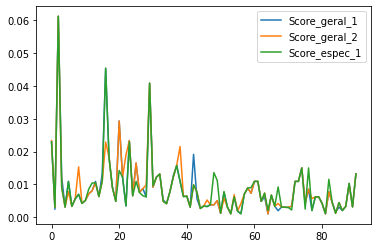

In [ ]:
vdf_scores.plot()

In [ ]:
vdf_num_ocur=vdf

In [ ]:
del vdf_num_ocur['Score_geral_1']
del vdf_num_ocur['Score_geral_2']
del vdf_num_ocur['Score_espec_1']
del vdf_num_ocur['latitude']
del vdf_num_ocur['longitude']

In [ ]:
vdf_num_ocur

,Num_oc_geral_1,Num_oc_geral_2,Num_oc_espec_1
0,10,10,10
1,11,9,9
2,2,2,2
3,5,5,5
4,13,13,13
...,...,...,...
86,14,14,14
87,9,9,9
88,14,14,14
89,10,10,10


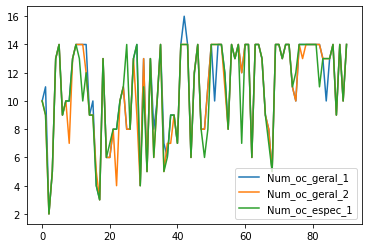

In [ ]:
vdf_num_ocur.plot()

## VISUALIZING ON FOLIUM RESULTS

## FINAL VISUALIZATION WITH KMEANS CLUSTER

### Mapping from found breweries

In [ ]:
map_sampa = folium.Map(location=[-23.56247,-46.63039],zoom_start=10)

for lat,lng, neighbourhood in zip(df['latitude'],df['longitude'],df['Neighborhood']):
    label = '{}'.format(neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_sampa)

In [ ]:
map_sampa

### Applying kmeans model - finding clusters

### K-Means

In [ ]:
df_f=df

In [ ]:
k=6
sampa_clust = df_f.drop(['Store_Name','Locality','Postal_Code','Street_Address','Street_Name','Number','Neighborhood'],1)
kmeans = KMeans(n_clusters = k,random_state=0).fit(sampa_clust)
kmeans.labels_
df_f.insert(0, 'ClusterLabels', kmeans.labels_)

In [ ]:
df_f.to_excel("Cervejarias em Sampa (Matriz Final - última versão - com Clusters).xlsx")

In [ ]:
df_f

,ClusterLabels,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Score_geral_1,Num_oc_geral_2,Score_geral_2,Num_oc_espec_1,Score_espec_1,latitude,longitude
0,2,The Old Beer Cervejaria Ltda,São Paulo,04583-020,"Rua Baltazar Fernandes, 54, Vl Gertrudes",Rua Baltazar Fernandes,54,Vl Gertrudes,10,0.022972,10,0.023334,10,0.022972,-23.619878,-46.693677
1,2,Choperia Nova Palace Ltda Me,São Paulo,04142-082,"Avenida Bosque Saúde, 2198, Bosque da Saúde",Avenida Bosque Saúde,2198,Bosque da Saúde,11,0.002410,9,0.003012,9,0.003012,-23.612507,-46.617928
2,5,Cervejaria Der Braumeister Paulista Ltda,São Paulo,04849-529,"Rua Treze Maio, 1947, Lj 423 Bela Vista",Rua Treze Maio,1947,Lj 423 Bela Vista,2,0.061224,2,0.061224,2,0.061224,-23.570553,-46.643525
3,1,Lanchonete Choperia Mallorca Ltda Epp,São Paulo,01037-001,"Rua Conselheiro Crispiniano, 65, Sé",Rua Conselheiro Crispiniano,65,Sé,5,0.012274,5,0.009149,5,0.009149,-23.546337,-46.640149
4,0,Plínio Bar e Choperia Ltda,São Paulo,02512-000,"Rua Bernardino Fanganiello, 282, Ap 102 Casa ...",Rua Bernardino Fanganiello,282,Ap 102 Casa Verde Baixa,13,0.003090,13,0.003090,13,0.003090,-23.512952,-46.658629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,4,Nevada Chopperia Lancheteria L,São Paulo,02341-001,"Avenida Nova Cantareira, 4055, Tucuruvi",Avenida Nova Cantareira,4055,Tucuruvi,14,0.002024,14,0.002079,14,0.002024,-23.465241,-46.616764
87,3,Chopps Frios Donn Ltda,São Paulo,05419-000,"Avenida Pedroso Morais, 221, Alto de Pinheiros",Avenida Pedroso Morais,221,Alto de Pinheiros,9,0.003289,9,0.003289,9,0.003289,-23.567733,-46.688796
88,4,General Galinha Choperia e Res,São Paulo,02033-010,"Avenida General Ataliba Leonel, 2493, Santana",Avenida General Ataliba Leonel,2493,Santana,14,0.010201,14,0.010191,14,0.010349,-23.508186,-46.626204
89,2,Brasimax Com Equip Sup Esc Se,São Paulo,03401-001,"Rua Antônio Barros, 2391, Ap 112 Vl Carrão",Rua Antônio Barros,2391,Ap 112 Vl Carrão,10,0.003175,10,0.003130,10,0.003130,-23.551103,-46.554006


### Clustering statistics

#### Scores Topic Word

In [ ]:
df_clt_scores = df_f.pivot_table(index='ClusterLabels', values=['Score_geral_1', 'Score_geral_2', 'Score_espec_1'] , aggfunc='mean')

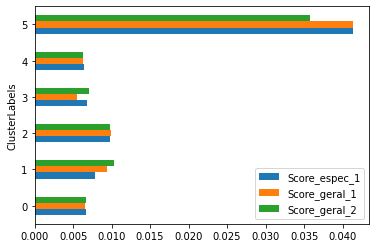

In [ ]:
df_clt_scores.plot.barh()

In [ ]:
df_clt_scores

,Score_espec_1,Score_geral_1,Score_geral_2
ClusterLabels,,,
0,0.006720,0.006510,0.006668
1,0.007798,0.009394,0.010346
2,0.009841,0.009971,0.009859
3,0.006819,0.005506,0.007131
4,0.006358,0.006259,0.006244
5,0.041411,0.041411,0.035786


#### Number of Quotes

In [ ]:
df_clt_numq = df_f.pivot_table(index='ClusterLabels', values=['Num_oc_geral_1', 'Num_oc_geral_2', 'Num_oc_espec_1'] , aggfunc='mean')

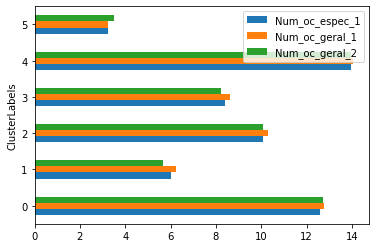

In [ ]:
df_clt_numq.plot.barh()

In [ ]:
df_clt_numq

,Num_oc_espec_1,Num_oc_geral_1,Num_oc_geral_2
ClusterLabels,,,
0,12.578947,12.789474,12.736842
1,6.000000,6.250000,5.666667
2,10.076923,10.307692,10.076923
3,8.384615,8.615385,8.230769
4,13.966667,14.066667,13.966667
5,3.250000,3.250000,3.500000


#### Geolocation analysis of clusters

In [ ]:
df_clt_geol_m = df_f.pivot_table(index='ClusterLabels', values=['latitude', 'longitude'] , aggfunc=['mean'])

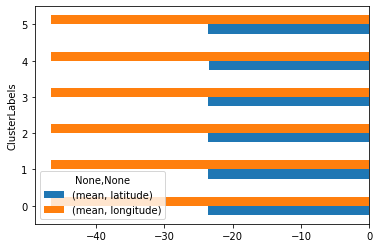

In [ ]:
df_clt_geol_m.plot.barh()

In [ ]:
df_clt_geol_s = df_f.pivot_table(index='ClusterLabels', values=['latitude', 'longitude'] , aggfunc=['std'])

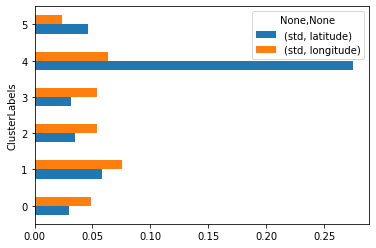

In [ ]:
df_clt_geol_s.plot.barh()

In [ ]:
df_clt_geol_m

mean           
                latitude  longitude
ClusterLabels                      
0             -23.547307 -46.633334
1             -23.569215 -46.613637
2             -23.580482 -46.632538
3             -23.553793 -46.652762
4             -23.511555 -46.634269
5             -23.566199 -46.620958

In [ ]:
df_clt_geol_s

std          
               latitude longitude
ClusterLabels                    
0              0.029983  0.048305
1              0.058379  0.075136
2              0.034780  0.054221
3              0.031247  0.053588
4              0.275316  0.063331
5              0.046191  0.023322

### Cluster Mapping

In [ ]:
# create map
map_clusters = folium.Map(location=[-23.562477,-46.630399],zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighbourhood, cluster in zip(df_f['latitude'], df_f['longitude'], df_f['Neighborhood'], df_f['ClusterLabels']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)



In [ ]:
map_clusters

## Load / Save the Processed File - Cervejarias em Sampa.xls

### LOAD

In [ ]:
df = pd.read_excel("Cervejarias em Sampa (Matriz Final - última versão) (3).xlsx")

df.drop("Unnamed: 0", inplace=True, axis=1)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Sscore_geral_1,Num_oc_geral_2,Sscore_geral_2,Num_oc_espec_1,Sscore_espec_1,latitude,longitude
0,The Old Beer Cervejaria Ltda,São Paulo,04583-020,"Rua Baltazar Fernandes, 54, Vl Gertrudes",Rua Baltazar Fernandes,54,Vl Gertrudes,10,0.022972,10,0.023334,10,0.022972,-23.619878,-46.693677
1,Choperia Nova Palace Ltda Me,São Paulo,04142-082,"Avenida Bosque Saúde, 2198, Bosque da Saúde",Avenida Bosque Saúde,2198,Bosque da Saúde,11,0.002410,9,0.003012,9,0.003012,-23.612507,-46.617928
2,Cervejaria Der Braumeister Paulista Ltda,São Paulo,04849-529,"Rua Treze Maio, 1947, Lj 423 Bela Vista",Rua Treze Maio,1947,Lj 423 Bela Vista,2,0.061224,2,0.061224,2,0.061224,-23.570553,-46.643525
3,Lanchonete Choperia Mallorca Ltda Epp,São Paulo,01037-001,"Rua Conselheiro Crispiniano, 65, Sé",Rua Conselheiro Crispiniano,65,Sé,5,0.012274,5,0.009149,5,0.009149,-23.546337,-46.640149
4,Plínio Bar e Choperia Ltda,São Paulo,02512-000,"Rua Bernardino Fanganiello, 282, Ap 102 Casa ...",Rua Bernardino Fanganiello,282,Ap 102 Casa Verde Baixa,13,0.003090,13,0.003090,13,0.003090,-23.512952,-46.658629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Nevada Chopperia Lancheteria L,São Paulo,02341-001,"Avenida Nova Cantareira, 4055, Tucuruvi",Avenida Nova Cantareira,4055,Tucuruvi,14,0.002024,14,0.002079,14,0.002024,-23.465241,-46.616764
87,Chopps Frios Donn Ltda,São Paulo,05419-000,"Avenida Pedroso Morais, 221, Alto de Pinheiros",Avenida Pedroso Morais,221,Alto de Pinheiros,9,0.003289,9,0.003289,9,0.003289,-23.567733,-46.688796
88,General Galinha Choperia e Res,São Paulo,02033-010,"Avenida General Ataliba Leonel, 2493, Santana",Avenida General Ataliba Leonel,2493,Santana,14,0.010201,14,0.010191,14,0.010349,-23.508186,-46.626204
89,Brasimax Com Equip Sup Esc Se,São Paulo,03401-001,"Rua Antônio Barros, 2391, Ap 112 Vl Carrão",Rua Antônio Barros,2391,Ap 112 Vl Carrão,10,0.003175,10,0.003130,10,0.003130,-23.551103,-46.554006


In [ ]:
df.rename(columns={'Sscore_geral_1': 'Score_geral_1', 'Sscore_geral_2': 'Score_geral_2', 'Sscore_espec_1': 'Score_espec_1'}, inplace=True)

df

,Store_Name,Locality,Postal_Code,Street_Address,Street_Name,Number,Neighborhood,Num_oc_geral_1,Score_geral_1,Num_oc_geral_2,Score_geral_2,Num_oc_espec_1,Score_espec_1,latitude,longitude
0,The Old Beer Cervejaria Ltda,São Paulo,04583-020,"Rua Baltazar Fernandes, 54, Vl Gertrudes",Rua Baltazar Fernandes,54,Vl Gertrudes,10,0.022972,10,0.023334,10,0.022972,-23.619878,-46.693677
1,Choperia Nova Palace Ltda Me,São Paulo,04142-082,"Avenida Bosque Saúde, 2198, Bosque da Saúde",Avenida Bosque Saúde,2198,Bosque da Saúde,11,0.002410,9,0.003012,9,0.003012,-23.612507,-46.617928
2,Cervejaria Der Braumeister Paulista Ltda,São Paulo,04849-529,"Rua Treze Maio, 1947, Lj 423 Bela Vista",Rua Treze Maio,1947,Lj 423 Bela Vista,2,0.061224,2,0.061224,2,0.061224,-23.570553,-46.643525
3,Lanchonete Choperia Mallorca Ltda Epp,São Paulo,01037-001,"Rua Conselheiro Crispiniano, 65, Sé",Rua Conselheiro Crispiniano,65,Sé,5,0.012274,5,0.009149,5,0.009149,-23.546337,-46.640149
4,Plínio Bar e Choperia Ltda,São Paulo,02512-000,"Rua Bernardino Fanganiello, 282, Ap 102 Casa ...",Rua Bernardino Fanganiello,282,Ap 102 Casa Verde Baixa,13,0.003090,13,0.003090,13,0.003090,-23.512952,-46.658629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,Nevada Chopperia Lancheteria L,São Paulo,02341-001,"Avenida Nova Cantareira, 4055, Tucuruvi",Avenida Nova Cantareira,4055,Tucuruvi,14,0.002024,14,0.002079,14,0.002024,-23.465241,-46.616764
87,Chopps Frios Donn Ltda,São Paulo,05419-000,"Avenida Pedroso Morais, 221, Alto de Pinheiros",Avenida Pedroso Morais,221,Alto de Pinheiros,9,0.003289,9,0.003289,9,0.003289,-23.567733,-46.688796
88,General Galinha Choperia e Res,São Paulo,02033-010,"Avenida General Ataliba Leonel, 2493, Santana",Avenida General Ataliba Leonel,2493,Santana,14,0.010201,14,0.010191,14,0.010349,-23.508186,-46.626204
89,Brasimax Com Equip Sup Esc Se,São Paulo,03401-001,"Rua Antônio Barros, 2391, Ap 112 Vl Carrão",Rua Antônio Barros,2391,Ap 112 Vl Carrão,10,0.003175,10,0.003130,10,0.003130,-23.551103,-46.554006


### SAVE

In [ ]:
df_f.to_excel("Cervejarias em Sampa (Matriz Final - última versão) (REV4).xlsx")